### 1W-QKD using QRWs on circles & hypercubes: analysis on security parameter $c$


The first code cells are a quicker way to avoid downloading all the necessary modules every time the code is rerun from start to finish.⚡

In [1]:
# Import qiskit, qiskit-aer, quantum_decomp && pylatexenc from Google Drive
'''
from google.colab import drive
import sys
drive.mount('/content/drive')
!pip install qiskit qiskit_aer pylatexenc quantum_decomp --target /content/drive/MyDrive/qkd_qrw_packages --upgrade
sys.path.append('/content/drive/MyDrive/qkd_qrw_packages')
'''

"\nfrom google.colab import drive\nimport sys\ndrive.mount('/content/drive')\n!pip install qiskit qiskit_aer pylatexenc quantum_decomp --target /content/drive/MyDrive/qkd_qrw_packages --upgrade\nsys.path.append('/content/drive/MyDrive/qkd_qrw_packages')\n"

In [2]:
# Alternatively...
!pip install qiskit qiskit_aer pylatexenc quantum_decomp --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.4 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=002e3b596c1713eb9358975e80204b44b8766b0285ce45ff703303cede0f2dbb
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [3]:
# Useful imports
import numpy as np
import warnings
import random

# Qiskit components
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import MCXGate
from qiskit_aer import AerSimulator
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (depolarizing_error, thermal_relaxation_error, amplitude_damping_error, phase_damping_error, phase_amplitude_damping_error,
                              coherent_unitary_error, pauli_error)
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import quantum_decomp as qd

# Visualization
from qiskit.visualization import plot_histogram, plot_state_city
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output

# Filter all warnings from now on
warnings.filterwarnings("ignore")

The following class encapsulates the quantum circuit and logic required to implement the QRW based on the specified dimension and target state. It inherits from the `QRW_Reg` class and provides methods for defining operators and visualization, making it a comprehensive implementation of the QRW algorithm definition.

In [4]:
class QRW_Reg:
    """
    QRW_Reg initializes a Quantum Random Walk registry
    dim: number of qubits in the state space
    c: number of coin qubits (rounded from log_2(dim))
    """
    def __init__(self, dim):
        # Calculate log₂(dim) and handle infinity
        log2_dim = np.log2(dim)
        if np.isinf(log2_dim):
            self.c = 0
        else:
            self.c = int(np.round(log2_dim))
        self.dim = dim
        self.n = int(dim + self.c)
        # Create registers
        self.qr = QuantumRegister(self.n, 'q')
        self.cl = ClassicalRegister(self.n, 'c')
        # Create circuit
        self.circuit = QuantumCircuit(self.qr, self.cl)

### QRW on a circle | decomposition

The next code cell contains the implementation of a **QRW on a circle**, designed using matrix-based definitions. In this scenario, the walker moves along discrete positions on a circle. The Hilbert space $H$, which describes the QRW, is the tensor product of the position Hilbert space $H_p$ and the coin Hilbert space $H_c$, i.e., $H = H_p \otimes H_c$. The position Hilbert space $H_p$ is spanned by points on a circle, denoted as $\{|x\rangle \, | \, x \in \{0, \dots, P - 1\} \}$, where $P$ is the total number of discrete positions. The coin Hilbert space $H_c$ is spanned by the two possible coin states $\{|R\rangle, \: |L\rangle \}$, representing heads and tails, respectively. The evolution of the QW for one step is governed by the unitary operator:

$$
U = S \cdot (I_p \otimes R_c)
$$

where $I_p$ is the identity operator in $H_p$, and $R_c \in SU(2)$ is a rotation in $H_c$. In its generical matrix form, $R_c$ can be written as:

$$
R_c(\theta, \phi) = \begin{bmatrix} e^{i \phi} \cos(\theta) & e^{i \phi} \sin(\theta) \\ -e^{-i \phi} \sin(\theta) & e^{-i \phi} \cos(\theta) \end{bmatrix}
$$

where $\phi$ denotes the phase angle of the rotation, and $\theta$ represents the actual rotation angle.

The shift operator $S$ moves the walker one position to the right or left on the circle, based on its coin state. Explicitly, $S$ is defined as:

$$
S = \sum_{x=0}^{P-1} \left( | x + 1 \ (\text{mod} \ P) \rangle \langle x | \otimes | R \rangle \langle R | + | x - 1 \ (\text{mod} \ P) \rangle \langle x | \otimes | L \rangle \langle L | \right)
$$

This operator shifts the walker either clockwise or counterclockwise, depending on the coin state. Since the walker is on a circle, position $P$ is identified with position $0$, creating a continuous loop of discrete steps.

In [5]:
class QRW_Circle(QRW_Reg):
    """
    The QRW_Circle class implements a QRW on a circle using a matrix-based definition
    dim: number of qubits in the state space
    c_label: string that determines what coin operator to use on the coin space
    - hadamard = Hadamard operator --> tensor product with the identity
    - generic_rotation = rotation operator with customizable parameters
    step: number of 'steps' the QRW completes
    """
    def __init__(self, dim, c_label, step):
        QRW_Reg.__init__(self, dim)
        self.circuit = QRW_Reg(dim).circuit
        quantum_reg = QRW_Reg(dim).qr
        classical_reg = QRW_Reg(dim).cl
        circ = self.circuit
        # Hadamards on all of the states
        circ.h(quantum_reg[0:self.n])
        for i in range(int(step)):
            circ.unitary(self.U(c_label), quantum_reg, label=f"U")
        # Measure the registry onto the classical bits
        circ.measure(quantum_reg, classical_reg)

    # Defining all of the operators for the QRW: S, C, U
    def S(self):
        """Shift operator for circular topology"""
        coin = self.c
        num_dir = int(2**coin)
        state = self.dim
        S = np.zeros((2**(coin + state), 2**(coin + state)))
        for i in range(num_dir):
            for j in range(2**state):
                # Circular shift using modulo
                j_bin = int(j)
                e_i = int(i + 1)
                shift = (j_bin + e_i) % (2**state) # circular shift
                row = shift + (i * (2**state))
                S[row][j + (i * (2**state))] = 1
        return Operator(S)

    def C(self, c_label, phi=0, theta=np.pi/4):
        coin = self.c
        state = self.dim
        # Create the identity in the S space
        I = np.zeros((2**state, 2**state))
        for i in range(2**state):
            I[i][i] = 1
        I = Operator(I)
        if c_label == "hadamard":
            result= np.zeros((2**coin, 2**coin))
            for i in range(2**coin):
                for j in range(2**coin):
                    if i >= 2 and j >= 2:
                        result[i][j] = (-1) * (-1)**(i * j) * (2**((-1) * (0.5 * coin)))
                    else:
                        result[i][j] = (-1)**(i * j) * (2**((-1) * (0.5 * coin)))
            res_op = (Operator(result))
            C_final = res_op.tensor(I)
            return C_final
        elif c_label == "generic_rotation":
            # Generic rotation operator for 2D coin
            if coin != 1:
                raise ValueError("Rotation operator only works with 1 coin qubit (2D coin space)")
            rotation = np.array([[np.exp(1j*phi) * np.cos(theta), np.exp(1j*phi) * np.sin(theta)],
                                 [-np.exp(-1j*phi) * np.sin(theta), np.exp(-1j*phi) * np.cos(theta)]
                                 ])
            res_op = Operator(rotation)
            C_final = res_op.tensor(I)
            return C_final
        else:
            raise TypeError("Label string for C is not a valid input!")

    def U(self, c_label):
        """Unitary operator combining shift and coin"""
        S_ = self.S()
        C_ = self.C(c_label)
        U = C_.compose(S_)
        return U

    # Visualization
    def draw_circuit(self):
        return self.circuit.draw("mpl")

    # Decompose curcuit using quantum_decomp tool
    def decompose_circuit(self, c_label="hadamard", steps=1):
        """
        Decomposes the QRW circuit using quantum_decomp
        """
        # Get the unitary matrix
        U_operator = self.U(c_label)
        U_matrix = np.array(U_operator.data)
        # Create new circuit
        n_qubits = int(np.log2(U_matrix.shape[0]))
        decomposed_circuit = QuantumCircuit(n_qubits)
        # Add initial Hadamards
        decomposed_circuit.h(range(n_qubits))
        # For each step, decompose and apply U operator
        for _ in range(steps):
            # Get decomposed circuit for U using quantum_decomp
            step_circuit = qd.matrix_to_qiskit_circuit(U_matrix)
            # Append the decomposed gates to our circuit
            decomposed_circuit = decomposed_circuit.compose(step_circuit)
        # Add measurements
        decomposed_circuit.measure_all()
        return decomposed_circuit

    def plot_states_hist(self, shots=10000, title=None):
        """
        Plot the histogram of measurement results using AerSimulator
        Args:
        shots (int): number of circuit executions (default: 10000)
        title (str): optional title for the histogram
        """
        # Create AerSimulator instance
        simulator = AerSimulator()
        # Execute the circuit
        job = simulator.run(self.circuit, shots=shots)
        # Get the results
        results = job.result()
        counts = results.get_counts()
        # Create the histogram
        fig, ax = plt.subplots(figsize=(12, 6))
        plot = plot_histogram(counts,
                            title=title or f'QRW results',
                            sort='value_desc',
                            ax=ax)
        # Customize the plot
        ax.set_xlabel('Measured states')
        ax.set_ylabel('Counts')
        plt.xticks(rotation=45)
        plt.tight_layout()

    def execute(self):
        """
        Execute the circuit once using AerSimulator
        """
        simulator = AerSimulator()
        # Execute with one shot
        job = simulator.run(self.circuit, shots=1)
        results = job.result()
        answer = results.get_counts()
        state = list(answer.keys())
        return state[0]

    # Get the probability distribution
    def get_probabilities(self, shots):
        """
        Get the probability distribution of states
        Args:
        shots (int): number of circuit executions
        Returns:
        dict: probability distribution of states
        """
        simulator = AerSimulator()
        job = simulator.run(self.circuit, shots=shots)
        results = job.result()
        counts = results.get_counts()
        # Convert counts to probabilities
        total = sum(counts.values())
        probabilities = {state: count/total for state, count in counts.items()}
        return probabilities

Since defining a generic unitary operator for higher dimensions is challenging, it's essential to find a way to decompose the final unitary operator, derived from our definition, into elementary Qiskit gates. To achieve this, we used the following tool: [quantum\_decomp](https://github.com/fedimser/quantum_decomp). Using the latter, we can break down the circuit into its components and analyze it step by step. After decomposition, we'll compare the probability distributions of the original matrix-based circuit and the decomposed one to determine if they are similar. This ensures that the approach is approximately correct. ✅

Let's test our QRW on a circle using a simple case. In this setup, we set `dim = 2`, which results in 8 possible states to explore. Furthermore, with `t = 2`, the walk will be executed twice before the measurement.

In [6]:
# Parameters to test
dim = 2
c_label = "generic_rotation"
t = 2
shots = 50000

In [7]:
# Definition of a QRW_Circle instance
qrw = QRW_Circle(dim=dim, c_label=c_label, step=t)

Circuit: 



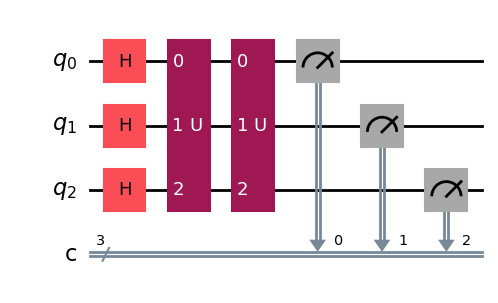

In [8]:
# Test the circuit drawing
print("Circuit: \n")
qrw.draw_circuit()

In [9]:
# Test probability distribution
print("Probability distribution:")
probs = qrw.get_probabilities(shots=shots)
for state, prob in probs.items():
    print(f"{state}: {prob:.4f}")

Probability distribution:
101: 0.1263
110: 0.1238
100: 0.1232
111: 0.1259
011: 0.1254
001: 0.1258
010: 0.1241
000: 0.1255


As observed above, the probability distribution is approximately uniform, which is a clear indication that simulations are working as intended. Now, let's decompose the unitary operator $U$, representing the evolution of the QRW, into a sequence of elementary quantum gates.

In [10]:
# Test decomposition
decomposed_circ = qrw.decompose_circuit(c_label=c_label, steps=t)

Decomposed circuit: 



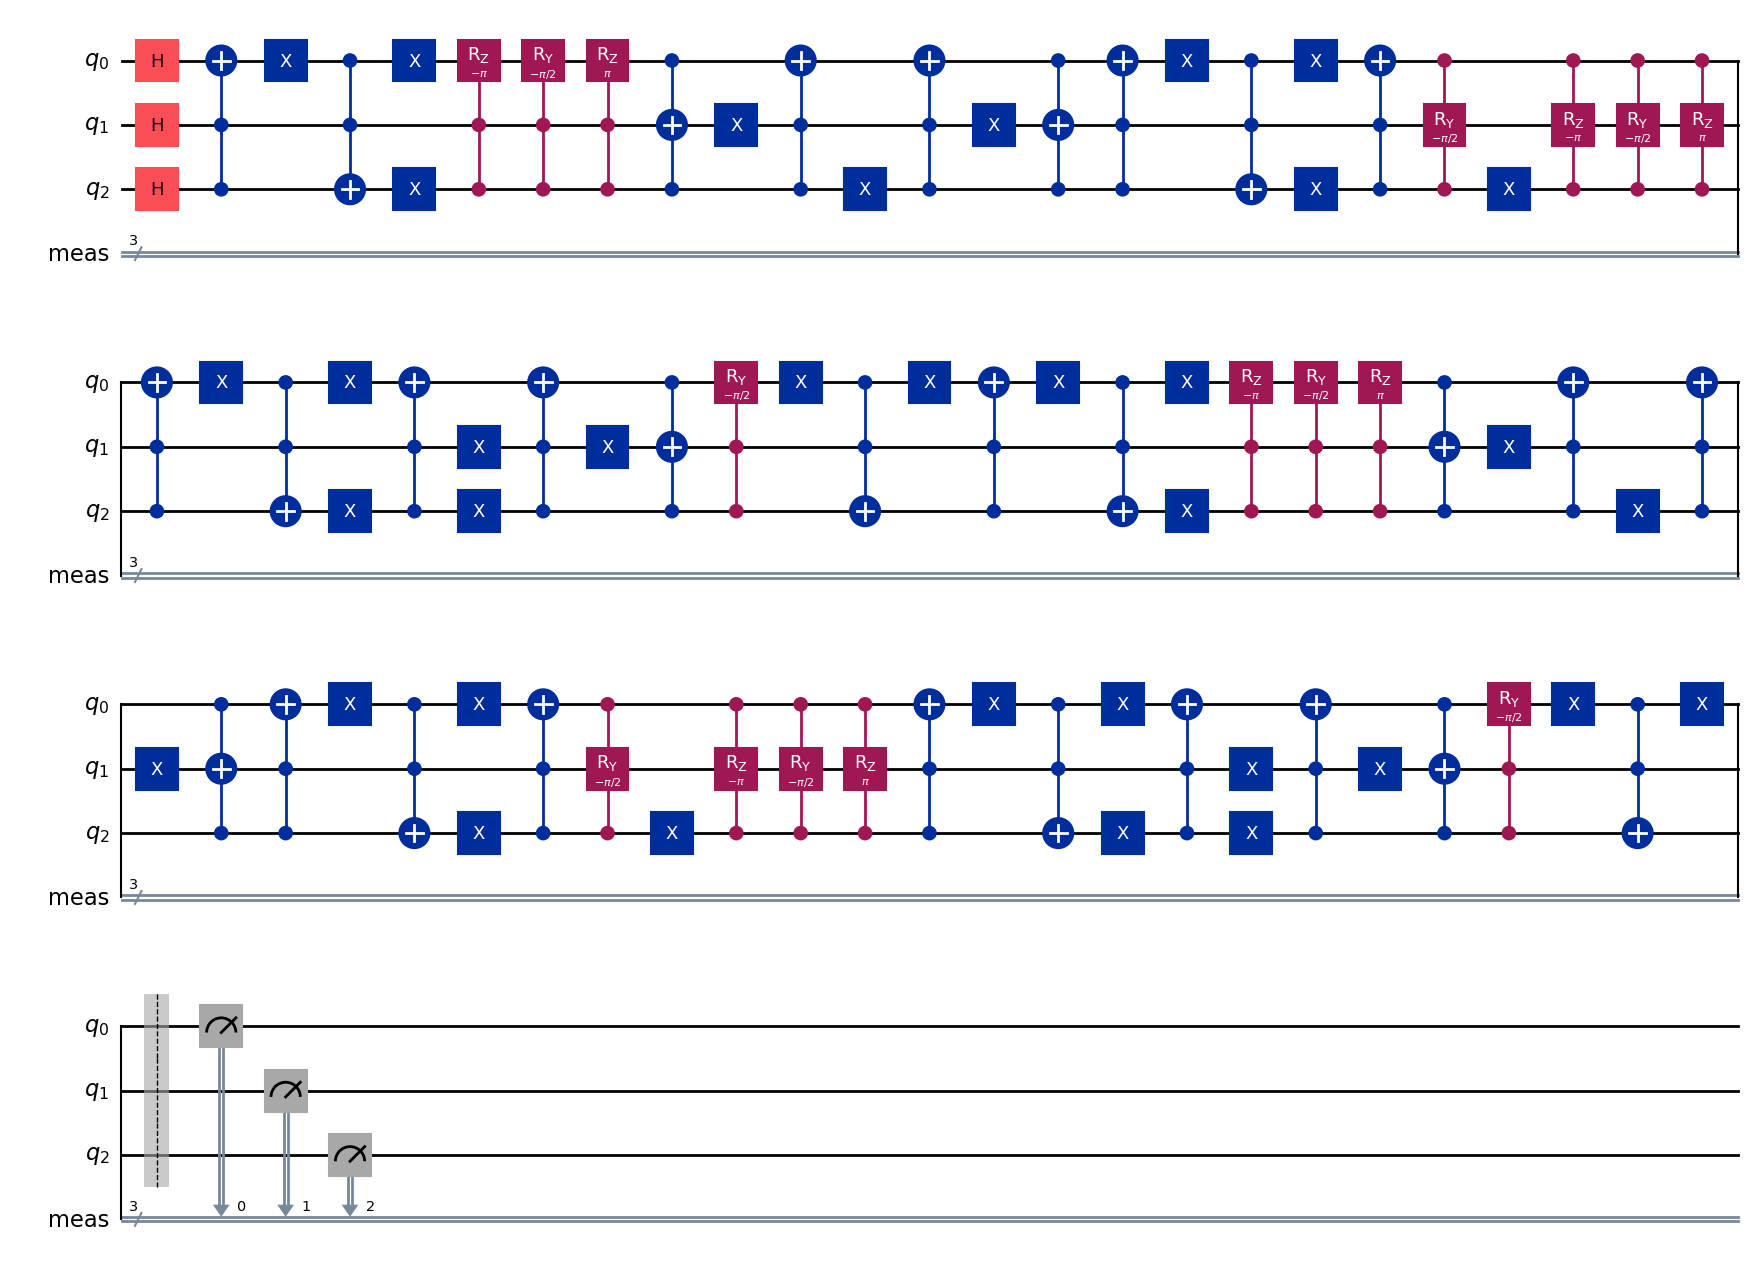

In [11]:
# Decomposed circuit visualization
print("Decomposed circuit: \n")
decomposed_circ.draw("mpl")

Let's compare the results after measurements for both cases: the **matrix-based** circuit and the **decomposed** one. Before running simulations, the decomposed circuit (shown above) needs to be transpiled, as the [quantum\_decomp](https://github.com/fedimser/quantum_decomp) tool might encounter issues translating all the gates into a format that Aer can simulate effectively.

Comparing original vs decomposed circuit results: 



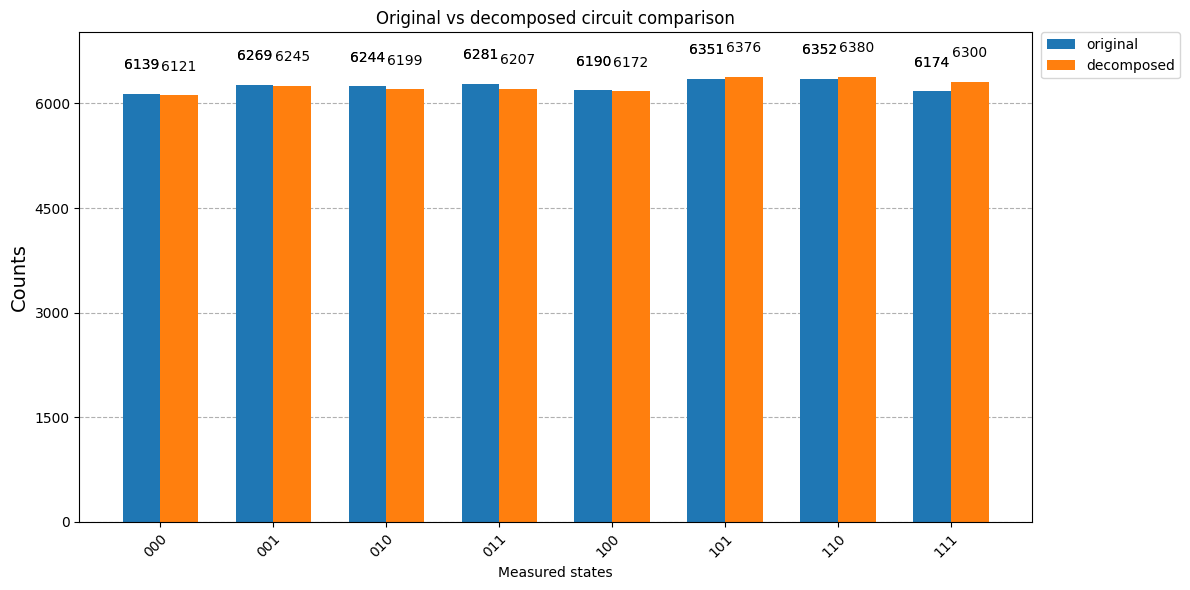

In [12]:
# Compare results
print("Comparing original vs decomposed circuit results: \n")

# Run both circuits
simulator = AerSimulator()

# Original circuit
original_counts = simulator.run(qrw.circuit, shots=shots).result().get_counts()

# Decomposed circuit
basis_gates = ['h', 'x', 'y', 'z', 'i', 's', 'sdg', 't', 'tdg', 'sx', 'sxdg', 'p',
               'rx', 'ry', 'rz', 'u', 'u1', 'u2', 'u3', 'cx', 'cy', 'cz', 'swap',
               'ch', 'cs', 'csdg', 'ct', 'ctdg', 'crx', 'cry', 'crz', 'cp', 'cu',
               'cu1', 'cu2', 'cu3', 'ccx', 'cswap']
transpiled_circ = transpile(decomposed_circ, basis_gates=basis_gates, optimization_level=1)
decomposed_counts = simulator.run(transpiled_circ, shots=shots).result().get_counts()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))
plot_histogram([original_counts, decomposed_counts],
               legend=['original', 'decomposed'],
               title='Original vs decomposed circuit comparison',
               ax=ax)
# Customize the plot
ax.set_xlabel('Measured states')
ax.set_ylabel('Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As observed above, the results are very promising, as the distributions are highly similar and closely resemble each other. We can conclude that defining the QRW using a matrix-based evolution $U$ and decomposing the unitary operator into quantum gates with the [quantum\_decomp](https://github.com/fedimser/quantum_decomp) tool are nearly equivalent in terms of obtained probability distributions (or counts distribution). ✅

Now, let's explore a more realistic scenario by implementing the QRW on two topologies: **circle** and **hypercube**. As mentioned earlier, defining a unitary operator $U$ to characterize the walk becomes increasingly challenging in higher dimensions. Therefore, we need to adopt a different approach to define the walk's evolution.

### QRW on a circle with a predefined number of positions $2P$


According to [B. L. Douglas et al.](https://arxiv.org/abs/0706.0304),
a QRW can be defined without explicitly constructing the matrices
associated with the walk evolution. Instead, it is possible to decompose
the QRW into elementary gates. The key idea is as follows:

- The shift operator, which moves the walker between positions, can be implemented as a series of **increment**/**decrement** gates. These gates can be represented using multi-qubit Toffoli gates, also known as **CCNOT (CCX)** gates;
- This allows the walker to move based on a simple sequence of elementary operations, avoiding the need to define the unitary operator as a full matrix (which becomes increasingly complex as the dimensions grow);
- To prepare the qubits for the walk, all position qubits and the coin qubit must be initialized in superposition using Hadamard gates;
- The coin operation (rotation or Grover coin) is applied before the shift, as usual.

This approach provides a more efficient way to define and execute QRWs on quantum hardware by leveraging elementary gates. Now, let's examine the code that defines a QRW on a circle with a specified number of positions.

In [13]:
class QRW_Circle_P(QRW_Reg):
    def __init__(self, P, step, F="I", coin_type="generic_rotation", phi=0, theta=np.pi/4):
        """
        Quantum Random Walk on a circle with P positions, based on B. L. Douglas et alt. paper
        Args:
        P (int): base number of positions on the circle (must be odd); the total number of positions in practice is 2*P
        step (int): number of steps to perform in the walk
        F (str): operator type for the coin flip ('I', 'X', or 'Y')
        coin_type (str): type of coin operation ('generic_rotation' or 'grover')
        phi (float): phase parameter for the rotation coin
        theta (float): rotation angle for the rotation coin
        """
        if P % 2 == 0:
            raise ValueError("P must be odd") # ensure P is odd for a proper circular topology
        self.P = P
        # Calculate the number of qubits required to represent P positions
        dim = int(np.ceil(np.log2(2 * P)))
        super().__init__(dim) # initialize parent class with dimension
        self.phi = phi
        self.theta = theta
        self.coin_type = coin_type
        self.F = F
        # Define quantum registers
        self.qnodes = QuantumRegister(dim, 'q')
        self.qcoin = QuantumRegister(1, 'c')
        self.cnodes = ClassicalRegister(dim, 'r')
        # Initialize the quantum circuit
        self.circuit = QuantumCircuit(self.qnodes, self.qcoin, self.cnodes)
        # Build the QRW circuit with the specified number of steps
        self._build_circuit(step)

    def cnx(self, *qubits):
        """
        Multi-controlled NOT gate
        Implements a controlled-NOT gate with multiple control qubits
        Args:
        qubits (list): list of control qubits followed by the target qubit
        """
        if len(qubits) >= 3:
            last = qubits[-1] # target qubit
            # Apply controlled rotations and recursive calls for multi-qubit control
            self.circuit.crz(np.pi/2, qubits[-2], qubits[-1])
            self.circuit.cp(np.pi/2, qubits[-2], qubits[-1])
            self.cnx(*qubits[:-2], qubits[-1]) # recursive call
            self.circuit.cp(-np.pi/2, qubits[-2], qubits[-1])
            self.cnx(*qubits[:-2], qubits[-1]) # recursive call
            self.circuit.crz(-np.pi/2, qubits[-2], qubits[-1])
        elif len(qubits) == 3:
            self.circuit.ccx(*qubits) # apply Toffoli gate
        elif len(qubits) == 2:
            self.circuit.cx(*qubits) # apply CNOT gate

    def increment_gate(self):
        """
        Increment the walker’s position modulo P
        """
        # Apply modular increment
        self.cnx(self.qcoin[0], *[self.qnodes[i] for i in range(len(self.qnodes))])
        self.circuit.barrier()

    def decrement_gate(self):
        """
        Decrement the walker’s position modulo P
        """
        # Apply modular decrement
        self.circuit.x(self.qcoin[0])
        for i in range(len(self.qnodes)):
            self.circuit.x(self.qnodes[i])
        self.cnx(self.qcoin[0], *[self.qnodes[i] for i in range(len(self.qnodes))])
        for i in range(len(self.qnodes)):
            self.circuit.x(self.qnodes[i])
        self.circuit.x(self.qcoin[0])
        self.circuit.barrier()
        qubits = [q for q in self.qnodes] # qubits representing position
        qubits.insert(0, self.qcoin[0]) # insert the coin qubit as a control
        # Apply multi-controlled NOT gates for increment operation
        self.cnx(*qubits)
        self.cnx(*qubits[:-1])
        self.cnx(*qubits[:-2])
        self.circuit.barrier() # add barrier for clarity

    def apply_operator_F(self, operator_type="I"):
        """
        Apply operator F to the coin qubit
        """
        if operator_type == "I":
            pass # identity, do nothing
        elif operator_type == "X":
            self.circuit.x(self.qcoin[0])
        elif operator_type == "Y":
            self.circuit.y(self.qcoin[0])
        else:
            raise ValueError("Invalid operator type. Choose 'I', 'X', or 'Y'.")

    def rotation_coin(self):
        """
        Apply a generic rotation coin operation to the coin qubit
        Coin matrix is defined by the angles theta and phi
        """
        cos_theta = np.cos(self.theta)
        sin_theta = np.sin(self.theta)
        exp_iphi = np.exp(1j * self.phi)
        exp_niphi = np.exp(-1j * self.phi)
        # Define the coin matrix
        coin_matrix = np.array([
            [exp_iphi * cos_theta, exp_iphi * sin_theta],
            [-exp_niphi * sin_theta, exp_niphi * cos_theta]
        ])
        # Apply the unitary transformation
        self.circuit.unitary(coin_matrix, [self.qcoin[0]], label='R')

    def grover_coin(self):
        """
        Placeholder for Grover coin operation
        """
        return np.eye(2)

    def coin_operation(self):
        """
        Apply the selected coin operation to the coin qubit
        """
        if self.coin_type == "generic_rotation":
            self.rotation_coin()
        elif self.coin_type == "grover":
            self.grover_coin()
        else:
            raise ValueError("Invalid coin type")
        self.circuit.barrier()

    def _build_circuit(self, step):
        """
        Build the quantum random walk circuit for the hypercube
        Args:
        step (int): number of walk steps to perform
        """
        # Initialize in uniform superposition
        for qubit in self.qnodes:
            self.circuit.h(qubit)
        self.circuit.h(self.qcoin)
        self.circuit.barrier()
        # Apply operator F to the coin
        self.apply_operator_F(operator_type=self.F)
        self.circuit.barrier()
        # Apply walk steps
        for _ in range(step):
            self.coin_operation()
            self.increment_gate()
            self.decrement_gate()
            self.circuit.barrier()
        # Measure
        self.circuit.measure(self.qnodes, self.cnodes)

    def draw_circuit(self):
        """
        Draw the quantum circuit
        """
        return self.circuit.draw("mpl")

    def plot_states_hist(self, shots=10000, title=None):
        """
        Plot a histogram of measurement results for valid states (0 to 2*P-1)
        Args:
        shots (int): number of circuit executions
        title (str): title for the histogram
        """
        simulator = AerSimulator()
        job = simulator.run(self.circuit, shots=shots)
        results = job.result()
        counts = results.get_counts()
        # Filter valid states
        valid_counts = {}
        for state, count in counts.items():
            if int(state, 2) < 2 * self.P: # only states 0 to 2*P-1
                valid_counts[state] = count
        # Plot histogram
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_histogram(valid_counts, title=title or f'QRW results (P={self.P})', sort='value_desc', ax=ax)
        ax.set_xlabel('Measured states')
        ax.set_ylabel('Counts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def execute(self):
        """
        Execute the circuit once and return a valid result state
        Returns a state in range 0 to 2*P-1
        """
        simulator = AerSimulator()
        valid_state = None
        # Keep trying until we get a valid state
        while valid_state is None:
            job = simulator.run(self.circuit, shots=1)
            results = job.result()
            answer = results.get_counts()
            state = list(answer.keys())[0]
            # Check if state is valid
            if int(state, 2) < 2 * self.P:
                valid_state = state
        return valid_state

    def get_probabilities(self, shots):
        """
        Get the probability distribution of valid states (0 to 2*P-1)
        Args:
        shots (int): number of circuit executions
        Returns:
        dict: probability distribution of valid states
        """
        simulator = AerSimulator()
        job = simulator.run(self.circuit, shots=shots)
        results = job.result()
        counts = results.get_counts()
        # Filter valid states (0 to 2*P-1)
        valid_counts = {}
        total_valid = 0
        for state, count in counts.items():
            state_val = int(state, 2)
            if state_val < 2 * self.P: # only include states within valid range
                valid_counts[state] = count
                total_valid += count
        # Normalize probabilities for valid states
        probabilities = {state: count/total_valid for state, count in valid_counts.items()}
        return probabilities

Let's explore an example to verify if our concept is implemented correctly. The expected outcome is a circuit composed of a series of controlled gates and rotations, enabling position shifts as previously defined. Additionally, the probability distribution across all possible states should be approximately uniform (or at least resemble uniformity).

In [14]:
# Test QRW on a circle with 2*P positions
qrw = QRW_Circle_P(P=11,
                   step=2,
                   coin_type="generic_rotation",
                   F="I",
                   phi=0,
                   theta=np.pi/4)

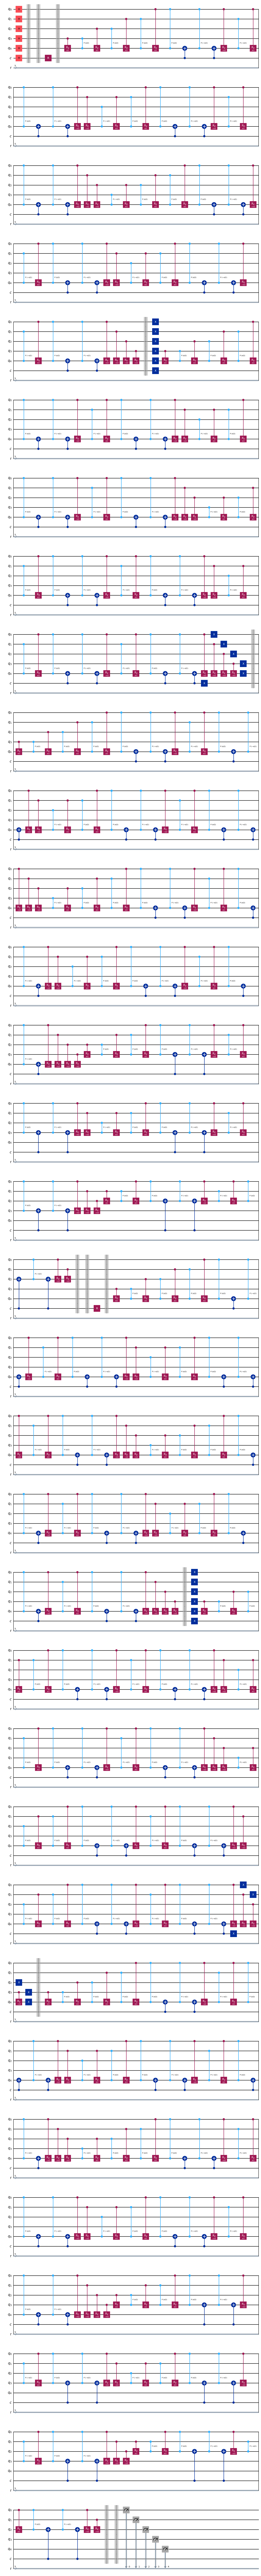

In [15]:
# Test circuit drawing
qrw.draw_circuit()

In [16]:
# Test probability distribution
print("Probability distribution:")
probs = qrw.get_probabilities(shots=shots)
for state, prob in probs.items():
    print(f"{state}: {prob:.4f}")

Probability distribution:
10100: 0.0441
00101: 0.0436
10001: 0.0449
01001: 0.0442
10000: 0.0453
00010: 0.0446
00111: 0.0446
00011: 0.0450
01000: 0.0467
01100: 0.0457
00100: 0.0461
01010: 0.0458
01101: 0.0462
10101: 0.0449
10010: 0.0440
00110: 0.0461
00001: 0.0449
01110: 0.0465
10011: 0.0467
01011: 0.0462
00000: 0.0472
01111: 0.0468


As we can see from above, the probability distribution is approximately uniform, which is clearly an optimal result, indicating that this approach is valid for constructing QRW evolutions using simpler gates. 🎉

Let us now examine the paper of [C. Vlachou et alt.](https://arxiv.org/abs/1710.07979), where simulations of a QRW on a circle are initially conducted to determine the $c$ parameter as $P$ varies.

In fact, to demonstrate the security of 1W-QKD, we will construct an equivalent entanglement-based protocol, as is commonly done. Proving the security of this protocol will also validate the security of the prepare-and-measure version. The equivalence between entanglement-based and prepare-and-measure QKD protocols was first introduced by Bennett, Brassard, and Mermin. Since then, the connection between entanglement (specifically, the ability to certify or distill it) and the security of prepare-and-measure QKD protocols has been extensively explored. A frequent method for proving the security of prepare-and-measure QKD protocols, including those presented in this work, involves considering an equivalent entanglement-based protocol.

Even in cases where the devices are untrusted (as in device-independent QKD), security holds under certain assumptions about the devices. For the entanglement-based protocol, in each of the $N$ iterations, we modify steps (1) and (2) as follows:

- **New step (1)**: Alice prepares the entangled state:
  $$
  |\Psi_0\rangle = \frac{1}{\sqrt{2P}} \sum_{i=0}^{2P-1} |i, \: i\rangle_{AB}
  $$

    which resides in a $4P^2$-dimensional Hilbert space, $(H_p \otimes H_c)^2$. Alice sends Bob the second half (the Bob portion) of $|\Psi_0\rangle$ while keeping the first half (the Alice portion) in her private lab;

- **New step (2)**: Alice and Bob independently choose two random bits, $w_A$ and $w_B$. If $w_A = 0$, Alice measures her half of the entangled state in the computational $Z$ basis; otherwise, she measures in the QRW basis. Bob similarly measures his half according to $w_B$. Their measurement outcomes are recorded as $i_A$ for Alice and $j_B$ for Bob.

Next, we prove the security of this entanglement-based protocol by initially making three assumptions:

- $A_1$: Alice and Bob only use iterations where $w_A = w_B = 0$ for their raw key;
- $A_2$: Eve is limited to collective attacks, where she independently attacks each protocol iteration but can perform a joint measurement of her ancilla at any future time;
- $A_3$: Eve prepares the states that Alice and Bob hold.

Assumption $A_1$ simplifies computation and can be discarded later; alternatively, Alice and Bob may bias their basis choice to make $w_A = w_B = 0$ more likely, as done in the BB84 protocol. Assumption $A_2$ can be removed later using a de Finetti argument, yielding security in the asymptotic limit without degrading the key-rate. Assumption $A_3$ grants more power to Eve; if security is shown with $A_3$, it holds even when $A_3$ is removed.

Given $A_2$ and $A_3$, Alice, Bob, and Eve, after $N$ iterations, share a quantum state $\rho_{ABE}^N$, where $\rho_{ABE} \in H_A \otimes H_B \otimes H_E$ with $H_A \simeq H_B \simeq H_p \otimes H_c$. Eve, as an all-powerful adversary, has no constraints on her Hilbert space $H_E$. After error correction and privacy amplification, Alice and Bob share a secret key of size $\ell(N)$. Under collective attacks, the Devetak-Winter key-rate expression can compute:

$$
r = \lim_{N \to \infty} \frac{\ell(N)}{N} = S(A|E) - H(A|B)
$$

Let $A_z$ and $A_w$ be random variables representing Alice's system when measured in the $Z$ or QW basis, respectively, with $B_z$ and $B_w$ defined similarly for Bob. Under $A_1$, we seek:

$$
r = S(A_z|E) - H(A_z|B_z)
$$

Computing $H(A_z|B_z)$ is straightforward, given the probabilities:

$$
p_{i,j}^z = \mathbb{P}(i_A = i, \: j_B = j | w_A = w_B = 0)
$$

The challenge lies in bounding the von Neumann entropy $S(A_z|E)$. For this, we use an uncertainty relation from which, given any density operator $\rho_{ABE}$ on $H_A \otimes H_B \otimes H_E$, and measurements using POVMs $M_0 = \{ M_x^{(0)} \}_x$ or $M_1 = \{ M_x^{(1)} \}_x$:

$$
S(A_0|E) + H(A_1|B) \geq \log \frac{1}{c}
$$

where $c = \max_{x,y} \| M_x^{(0)} M_y^{(1)} \|_\infty^2$; we define $\| \cdot \|_\infty$ as the operator norm, with $A_i$ representing the random variable that describes Alice's system after applying the measurement $M_i$. We will define $B_i$ similarly for Bob's system. Assuming measurements $M_0$ are used for key distillation, provides the Devetak-Winter key rate:

$$
r = S(A_0|E) - H(A_0|B_0) \geq \log \frac{1}{c} - H(A_0|B_0) - H(A_1|B) \geq \log \frac{1}{c} - H(A_0|B_0) - H(A_1|B_1)
$$

This final inequality results from the fundamental fact that measurements can only increase entropy. In our scenario, we set $M^{(0)}_x = |x\rangle \langle x|$ and $M^{(1)}_x = |\tilde{x}\rangle \langle\tilde{x}|$ for $x \in \{0, 1, \dots, 2P - 1\}$, where $|\tilde{x}\rangle = \sum_{i}\alpha_{x,i} \: |i\rangle$. Thus, for all $x, y$:

$$
\| M^{(0)}_x M^{(1)}_y \|_\infty = |\alpha_{x, y}|^2
$$

This results in:

$$
c = \max_{x,y} |\alpha_{x, y}|^2
$$

which depends only on the QRW parameters and not on the channel noise. Therefore, Alice and Bob should choose optimal values for $t$, $\theta$, and $P$ to minimize $c$, thereby maximizing the key rate.

As previously mentioned, the value of $c$ depends solely on the QRW parameters, which are under Alice and Bob's control. They should select a QW setup that minimizes this value so that, after evolving for $t$ steps, the probability of the walker occupying any specific position remains low. It's evident that as $t \to \infty$, the values $|\alpha_{x, y}|$ do not settle into a steady state, which is why time-averaged distributions are often considered when analyzing QRWs on cycles.

However, for our QKD protocol, we are not concerned with large $t$; instead, we seek an optimal, reasonably small $t$. Larger values of $t$ generally mean longer preparation and reversal times for Alice and Bob, respectively. In that case, the choice of $t$ affects noise resistance rather than making it more difficult for Eve to distinguish. Even small values of $t$ (e.g., $t = 1$ or $t = 2$) can yield secure systems. Different values of $t$ lead to various noise tolerances, and we seek optimal $t$ values, where “optimal” refers to maximizing theoretical noise tolerance for a given walk configuration.

We begin by exploring various walk parameters to find the minimum $c$ value, starting with $F = I_c$, the identity operator. Notably, on a circle, it is generally practical to consider odd $P$ values, as even $P$ forces the probability amplitudes onto only even or odd nodes, thereby increasing $|\alpha_{x, y}|$.

In this case, we are focused on understanding how the security parameter $c$ can be minimized by choosing the optimal $t$. For simplicity, an optimal $t$ should ideally be low, ensuring that the computation (and consequently the quantum circuit) remains easy to manage. To address this, we introduce a
`significant_threshold` parameter to avoid considering larger $t$ when the minimal value of $c$ does not decrease below the imposed threshold. This allows us to determine an optimal $t$ that balances minimizing $c$ with feasibility in simulations.

In [17]:
# Generate all odd P values from 1 to 229
P_values = list(range(1, 230, 2))
results = [] # store (P, c, log_inv_c, optimal_t) values
# Parameters
theta = np.pi / 4
phi = 0
shots = 10000
print("P\tmin_c\tlog_2(1/c)\tt")
print("-" * 38)
for P in P_values:
    # Set t_range based on P value
    if P <= 13:
        t_range = range(1, 5000)
    elif P >= 79:
        t_range = range(1, 50000)
    min_c = 0.5
    optimal_t = 1
    significant_threshold = 1e-03 # define a threshold for significant change in c
    # Search for optimal t
    previous_c = 1 # start with a value larger than any c
    for t in t_range:
        qrw = QRW_Circle_P(P=P,
                           step=t,
                           coin_type="generic_rotation",
                           F="I",
                           phi=phi,
                           theta=theta)
        probs = qrw.get_probabilities(shots=shots)
        c = max(probs.values())
        if c < min_c:
            min_c = c
            optimal_t = t
        elif abs(c - previous_c) < significant_threshold:
            # Stop exploring further if there's no significant change
            break
        previous_c = c
    log_inv_c = -np.log2(min_c)
    results.append((P, min_c, log_inv_c, optimal_t))
    print(f"{P}\t{min_c:.4f}\t{log_inv_c:.4f}\t{optimal_t}")

P	min_c	log_2(1/c)	t
--------------------------------------
1	0.5000	1.0000	1
3	0.1709	2.5488	1
5	0.1031	3.2774	5
7	0.0741	3.7552	5
9	0.0602	4.0550	2
11	0.0515	4.2796	1
13	0.0421	4.5701	1
15	0.0365	4.7766	1
17	0.0351	4.8307	3
19	0.0305	5.0329	3
21	0.0268	5.2228	5
23	0.0247	5.3414	4
25	0.0235	5.4121	1
27	0.0211	5.5651	3
29	0.0205	5.6068	1
31	0.0185	5.7594	2
33	0.0187	5.7393	2
35	0.0186	5.7502	1
37	0.0167	5.9081	5
39	0.0159	5.9726	3
41	0.0152	6.0412	5
43	0.0143	6.1239	2
45	0.0136	6.1962	4
47	0.0131	6.2501	2
49	0.0129	6.2711	3
51	0.0117	6.4198	2
53	0.0119	6.3927	1
55	0.0118	6.4032	2
57	0.0115	6.4363	1
59	0.0105	6.5700	1
61	0.0100	6.6495	2
63	0.0098	6.6773	4
65	0.0104	6.5895	3
67	0.0110	6.5072	1
69	0.0102	6.6187	1
71	0.0096	6.6981	2
73	0.0091	6.7744	2
75	0.0095	6.7111	1
77	0.0088	6.8233	2
79	0.0092	6.7573	2
81	0.0087	6.8489	2
83	0.0093	6.7462	1
85	0.0080	6.9601	3
87	0.0085	6.8721	2
89	0.0080	6.9744	2
91	0.0081	6.9546	1
93	0.0075	7.0519	3
95	0.0074	7.0747	1
97	0.0078	7.0101	1
99	0.0070	7.15

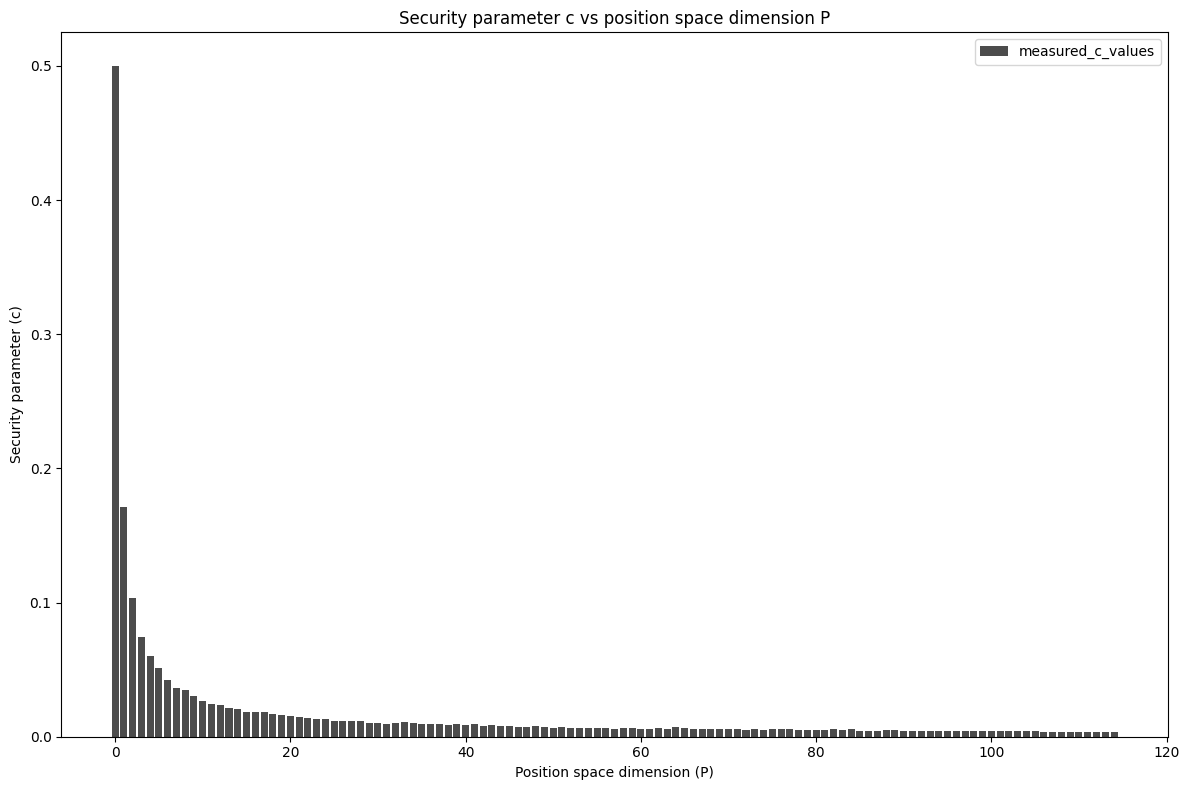

In [18]:
# Extract P values and their associated probabilities
P_vals = [p for p, c, _, _ in results]
probs = [c for p, c, _, _ in results]
# Create figure
plt.figure(figsize=(12, 8))
# Create bar plot
bars = plt.bar(range(len(P_vals)), probs, width=0.8, color='black', alpha=0.7, label='measured_c_values')
# Customize plot
plt.title('Security parameter c vs position space dimension P')
plt.xlabel('Position space dimension (P)')
plt.ylabel('Security parameter (c)')
plt.grid(False)
plt.legend()
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

As anticipated, the trend aligns with our expectations, showing a decrease that closely resembles an exponential pattern. This is (approximately) the result we aimed to achieve! 🥳

For comparisons, please refer to **figure 3** of [C. Vlachou et alt.](https://arxiv.org/abs/1710.07979) paper. ⚠️

In [19]:
# Save results to file
with open('c_qrw_circle_results.txt', 'w') as f:
    f.write("P\tc\tlog_2(1/c)\toptimal_t\n")
    for P, c, log_c, t in results:
        f.write(f"{P}\t{c:.6f}\t{log_c:.6f}\t{t}\n")

### QRW on a hypercube with a predefined number of vertices $2^{P}$

We can now extend the procedure described in [B. L. Douglas et al.](https://arxiv.org/abs/0706.0304) to implement a QRW evolution on a hypercube topology. In this case, the circuit design becomes more complex, as the **increment** and **decrement** gates must be applied in each "direction" of the walk. Unlike the previous scenario where the vertices were limited to $P$, the number of vertices now scales to $2^{P}$, meaning the probability distribution is spread across a significantly larger state space. Furthermore, the number of qubits required for the circuit increases substantially: with $2^{P}$ vertices, the number of qubits is $\text{log}_{2}(2^{P}) = P$.

In [20]:
class QRW_Hypercube_P(QRW_Reg):
    def __init__(self, P, step, F="I", coin_type="generic_rotation", phi=0, theta=np.pi/4):
        """
        Quantum Random Walk on a hypercube with 2**P vertices, based on B. L. Douglas et alt. paper
        Args:
        P (int): dimension of the hypercube (2**P vertices)
        step (int): number of walk steps to perform
        F (str): operator type for the coin flip ('I', 'X', or 'Y')
        coin_type (str): type of coin operation to use ('generic_rotation' or 'grover')
        phi (float): phase parameter for the generic rotation coin
        theta (float): angle parameter for the generic rotation coin
        """
        super().__init__(P)
        self.P = P # dimension of the hypercube
        self.vertices = 2**P # total number of vertices in the hypercube
        self.F = F # operator applied to the coin qubit
        self.phi = phi # phase parameter for coin operation
        self.theta = theta # angle parameter for coin operation
        self.coin_type = coin_type # type of coin to apply
        # Create quantum and classical registers
        self.qnodes = QuantumRegister(P, 'q')
        self.qcoin = QuantumRegister(1, 'c')
        self.cnodes = ClassicalRegister(P, 'r')
        # Initialize the quantum circuit
        self.circuit = QuantumCircuit(self.qnodes, self.qcoin, self.cnodes)
        # Build the circuit with the specified number of steps
        self._build_circuit(step)

    def cnx(self, *qubits):
        """
        Multi-controlled NOT gate
        Implements a controlled-NOT gate with multiple control qubits
        Args:
        qubits (list): list of control qubits followed by the target qubit
        """
        if len(qubits) >= 3:
            last = qubits[-1] # target qubit
            # Apply controlled rotations and recursive calls for multi-qubit control
            self.circuit.crz(np.pi/2, qubits[-2], qubits[-1])
            self.circuit.cp(np.pi/2, qubits[-2], qubits[-1])
            self.cnx(*qubits[:-2], qubits[-1]) # recursive call
            self.circuit.cp(-np.pi/2, qubits[-2], qubits[-1])
            self.cnx(*qubits[:-2], qubits[-1]) # recursive call
            self.circuit.crz(-np.pi/2, qubits[-2], qubits[-1])
        elif len(qubits) == 3:
            self.circuit.ccx(*qubits) # apply Toffoli gate
        elif len(qubits) == 2:
            self.circuit.cx(*qubits) # apply CNOT gate

    def increment_gate(self, direction):
        """
        Increment the walker’s position in a specific direction
        Args:
        direction (int): dimension of the hypercube in which to increment
        """
        qubits = [q for q in self.qnodes] # qubits representing position
        qubits.insert(0, self.qcoin[0]) # insert the coin qubit as a control
        # Apply multi-controlled NOT gates for increment operation
        self.cnx(*qubits)
        self.cnx(*qubits[:-1])
        self.cnx(*qubits[:-2])
        self.circuit.barrier() # add barrier for clarity

    def decrement_gate(self, direction):
        """
        Decrement the walker’s position in a specific direction
        Args:
        direction (int): dimension of the hypercube in which to decrement
        """
        qubits = [q for q in self.qnodes]
        qubits.insert(0, self.qcoin[0])
        # Flip the coin qubit to enable controlled decrement
        self.circuit.x(self.qcoin[0])
        # Flip the position qubits to prepare for decrement
        for i in range(2, -1, -1):
            self.circuit.x(self.qnodes[i])
        self.cnx(*qubits) # controlled decrement operation
        # Restore the position qubits
        self.circuit.x(self.qnodes[1])
        self.cnx(*qubits[:-1])
        self.circuit.x(self.qnodes[2])
        self.cnx(*qubits[:-2])
        # Restore the coin qubit
        self.circuit.x(self.qcoin[0])

    def rotation_coin(self):
        """
        Apply a generic rotation coin operation to the coin qubit
        Coin matrix is defined by the angles theta and phi
        """
        cos_theta = np.cos(self.theta)
        sin_theta = np.sin(self.theta)
        exp_iphi = np.exp(1j * self.phi)
        exp_niphi = np.exp(-1j * self.phi)
        # Define the coin matrix
        coin_matrix = np.array([
            [exp_iphi * cos_theta, exp_iphi * sin_theta],
            [-exp_niphi * sin_theta, exp_niphi * cos_theta]
        ])
        # Apply the unitary transformation
        self.circuit.unitary(coin_matrix, [self.qcoin[0]], label='R')

    def apply_operator_F(self, operator_type="I"):
        """
        Apply operator F to the coin qubit
        """
        if operator_type == "I":
            pass # identity, do nothing
        elif operator_type == "X":
            self.circuit.x(self.qcoin[0])
        elif operator_type == "Y":
            self.circuit.y(self.qcoin[0])
        else:
            raise ValueError("Invalid operator type. Choose 'I', 'X', or 'Y'.")

    def grover_coin(self):
        """
        Placeholder for Grover coin operation
        """
        return np.eye(2)

    def coin_operation(self):
        """
        Apply the selected coin operation to the coin qubit
        """
        if self.coin_type == "generic_rotation":
            self.rotation_coin()
        elif self.coin_type == "grover":
            self.grover_coin()
        else:
            raise ValueError("Invalid coin type")
        self.circuit.barrier()

    def _build_circuit(self, step):
        """
        Build the quantum random walk circuit for the hypercube
        Args:
        step (int): number of walk steps to perform
        """
        # Initialize all position qubits in superposition
        for qubit in self.qnodes:
            self.circuit.h(qubit)
        self.circuit.h(self.qcoin[0]) # initialize the coin qubit in superposition
        self.circuit.barrier()
        # Apply operator F to the coin
        self.apply_operator_F(operator_type=self.F)
        self.circuit.barrier()
        # Perform the quantum walk for the specified number of steps
        for _ in range(step):
            self.coin_operation() # apply coin operation
            for direction in range(self.P): # move along each dimension
                self.increment_gate(direction)
                self.decrement_gate(direction)
            self.circuit.barrier()
        # Measure the position qubits
        self.circuit.measure(self.qnodes, self.cnodes)

    def draw_circuit(self):
        """
        Draw the quantum circuit
        """
        return self.circuit.draw("mpl")

    def plot_states_hist(self, shots=10000, title=None):
        """
        Plot a histogram of measurement results for valid states (0 to 2*P-1)
        Args:
        shots (int): number of circuit executions
        title (str): title for the histogram
        """
        simulator = AerSimulator()
        job = simulator.run(self.circuit, shots=shots)
        results = job.result()
        counts = results.get_counts()
        # Filter valid states
        valid_counts = {}
        for state, count in counts.items():
            if int(state, 2) < 2 ** self.P: # only states 0 to 2**P - 1
                valid_counts[state] = count
        # Plot histogram
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_histogram(valid_counts, title=title or f'QRW results (P={self.P})', sort='value_desc', ax=ax)
        ax.set_xlabel('Measured states')
        ax.set_ylabel('Counts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def execute(self):
        """
        Execute the circuit once and return a valid result state
        Returns a state in range 0 to 2**P - 1
        """
        simulator = AerSimulator()
        valid_state = None
        # Keep trying until we get a valid state
        while valid_state is None:
            job = simulator.run(self.circuit, shots=1)
            results = job.result()
            answer = results.get_counts()
            state = list(answer.keys())[0]
            # Check if state is valid
            if int(state, 2) < 2 ** self.P:
                valid_state = state
        return valid_state

    def get_probabilities(self, shots):
        """
        Get the probability distribution of valid states (0 to 2**P - 1)
        Args:
        shots (int): number of circuit executions
        Returns:
        dict: probability distribution of valid states
        """
        simulator = AerSimulator()
        job = simulator.run(self.circuit, shots=shots)
        results = job.result()
        counts = results.get_counts()
        # Filter valid states (0 to 2**P - 1)
        valid_counts = {}
        total_valid = 0
        for state, count in counts.items():
            state_val = int(state, 2)
            if state_val < 2 ** self.P: # only include states within valid range
                valid_counts[state] = count
                total_valid += count
        # Normalize probabilities for valid states
        probabilities = {state: count/total_valid for state, count in valid_counts.items()}
        return probabilities

As before, let's explore an example to verify if our QRW is implemented correctly. The expected outcome is a circuit composed of a series of controlled gates and rotations, enabling position shifts as previously defined. Additionally, the probability distribution across all possible states should be approximately uniform (or at least resemble uniformity).

In [21]:
# Test QRW on a hypercube with 2**P vertices
qrw = QRW_Hypercube_P(P=3,
                      step=2,
                      F="I",
                      coin_type="generic_rotation",
                      phi=0,
                      theta=np.pi/4)

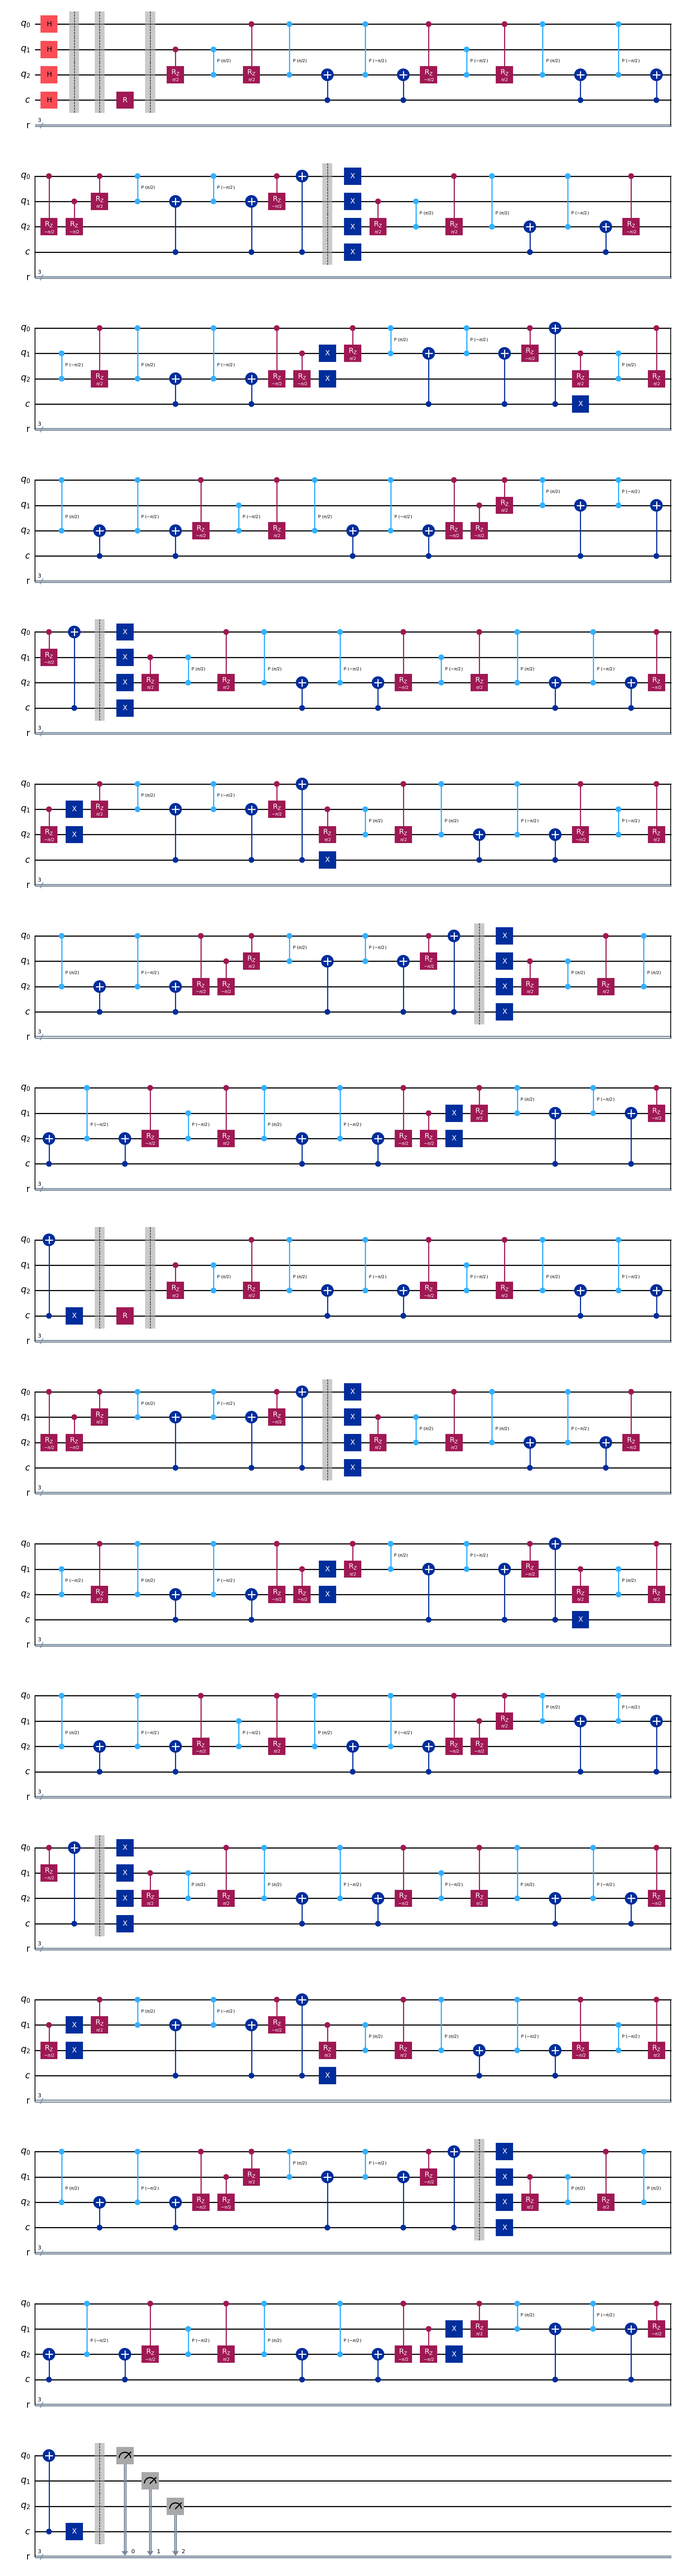

In [22]:
# Test circuit drawing
qrw.draw_circuit()

In [23]:
# Test probability distribution
print("Probability distribution:")
probs = qrw.get_probabilities(shots=shots)
for state, prob in probs.items():
    print(f"{state}: {prob:.4f}")

Probability distribution:
001: 0.1233
101: 0.1314
100: 0.1268
000: 0.1189
010: 0.1267
011: 0.1239
111: 0.1254
110: 0.1236


As observed above, the probability distribution is also approximately uniform in this case, providing a good starting point to validate the procedure used. ✅

Next, just as we did for the circle topology, we will perform **exactly** the same analysis for the hypercube topology to evaluate the security parameter $c$ as a function of $P$. Specifically, we will examine how the topology influences $c$, considering the exponential growth in the number of vertices and the resulting impact on circuit complexity.

In [24]:
# Generate all odd P values from 3 to 15
P_values = list(range(3, 16, 2))
results = [] # store (P, c, log_inv_c, optimal_t) values
# Parameters
theta = np.pi / 4
phi = 0
shots = 10000
print("P\tmin_c\tlog_2(1/c)\tt")
print("-" * 38)
for P in P_values:
    # Set t_range based on P value
    if P <= 13:
        t_range = range(1, 5000)
    elif P >= 79:
        t_range = range(1, 50000)
    min_c = 0.5
    optimal_t = 1
    significant_threshold = 1e-04 # define a threshold for significant change in c
    # Search for optimal t
    previous_c = 1 # start with a value larger than any c
    for t in t_range:
        qrw = QRW_Hypercube_P(P=P,
                              step=t,
                              F="I",
                              coin_type="generic_rotation",
                              phi=phi,
                              theta=theta)
        probs = qrw.get_probabilities(shots=shots)
        c = max(probs.values())
        if c < min_c:
            min_c = c
            optimal_t = t
        elif abs(c - previous_c) < significant_threshold:
            # Stop exploring further if there's no significant change
            break
        previous_c = c
    log_inv_c = -np.log2(min_c)
    results.append((P, min_c, log_inv_c, optimal_t))
    print(f"{P}\t{min_c:.4f}\t{log_inv_c:.4f}\t{optimal_t}")

P	min_c	log_2(1/c)	t
--------------------------------------
3	0.1265	2.9828	20
5	0.0336	4.8954	9
7	0.0100	6.6439	2
9	0.0033	8.2433	2
11	0.0013	9.5873	1
13	0.0008	10.2877	1
15	0.0004	11.2877	1


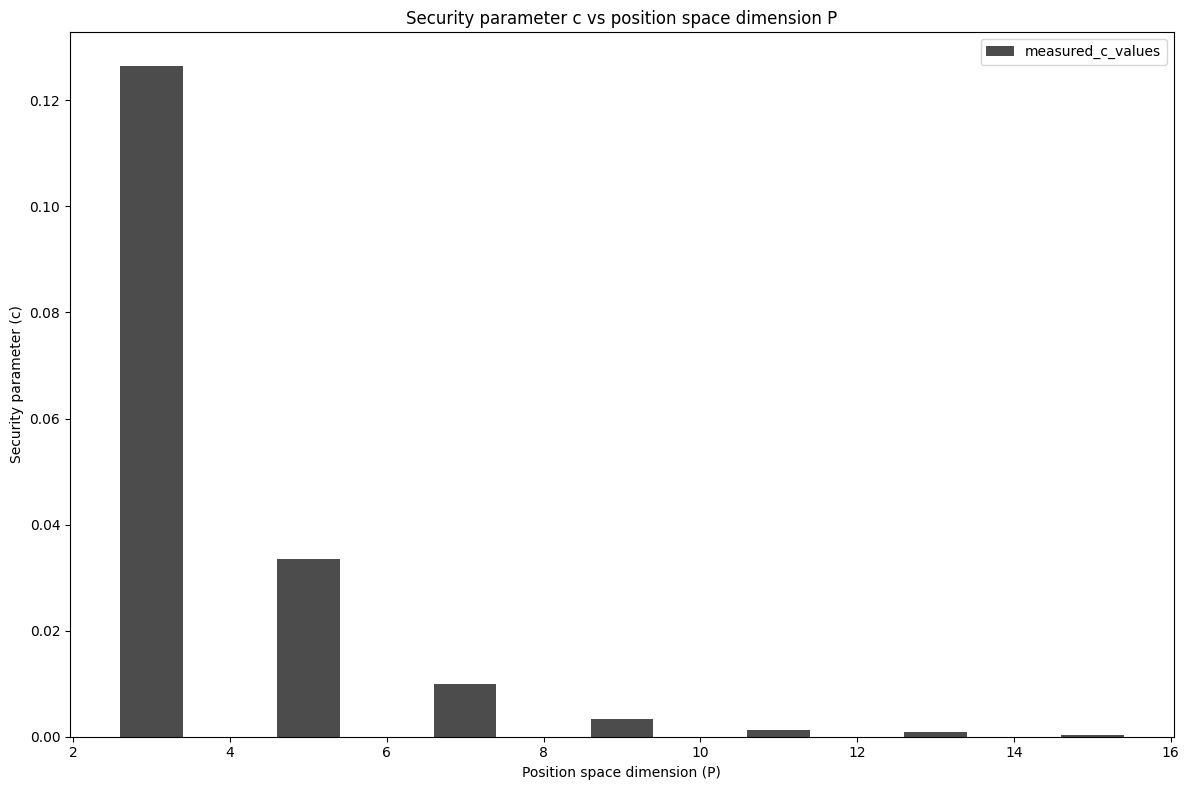

In [25]:
# Extract P and c values from results
P_vals = [p for p, c, _, _ in results]
c_vals = [c for p, c, _, _ in results]
plt.figure(figsize=(12, 8))
# Bar plot for actual values
plt.bar(P_vals, c_vals,
        width=0.8,
        color='black',
        alpha=0.7,
        label='measured_c_values')
# Customize plot
plt.title('Security parameter c vs position space dimension P')
plt.xlabel('Position space dimension (P)')
plt.ylabel('Security parameter (c)')
plt.grid(False)
plt.legend()
# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

Unfortunately, we are unable to test the code with values of $P$ greater than 13, as the RAM usage becomes excessive for such large circuits. However, this limitation is not a significant issue in practice because we can obtain the results from the QRW circle simulations with smaller values of $P$ (or even better!). This aligns precisely with our expectations from these simulations, demonstrating that even with smaller dimensions, we can achieve incredible results! 😊

This means that the 1W-QKD protocol using **hypercubes** will be significantly more secure. As the security parameter $c$ approaches 0, the system becomes nearly perfect in terms of resisting eavesdropping, making it highly secure.

In [26]:
# Save results to file
with open('c_qrw_hypercube_results.txt', 'w') as f:
    f.write("P\tc\tlog_2(1/c)\toptimal_t\n")
    for P, c, log_c, t in results:
        f.write(f"{P}\t{c:.6f}\t{log_c:.6f}\t{t}\n")